In [1]:
import utils.modelling_lib_rodrixx as mod
import utils.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

Rk               Player Pos  Age   Tm   G  GS  MP_pg  FG_pg  FGA_pg  ...  \
0   1  Kareem Abdul-Jabbar   C   32  LAL  82 -10   38.3   10.2    16.9  ...   
1   2        Tom Abernethy  PF   25  GSW  67 -10   18.2    2.3     4.7  ...   
2   3          Alvan Adams   C   25  PHO  75 -10   28.9    6.2    11.7  ...   
3   4       Tiny Archibald  PG   31  BOS  80  80   35.8    4.8     9.9  ...   
4   5        Dennis Awtrey   C   31  CHI  26 -10   21.5    1.0     2.3  ...   

   DBPM_rank  BPM_rank  VORP_rank     %W  GT  %W_rank     %G  Votes  Share  \
0          7         2          1  0.732  82        2  1.000    147  0.665   
1         32        54         41  0.293  82       44  0.817      0  0.000   
2         11        12         12  0.671  82        6  0.915      0  0.000   
3         33        31         20  0.744  82        1  0.976      2  0.009   
4         21        56         42  0.366  82       38  0.317      0  0.000   

   MaxVotes  
0       221  
1       221  
2       221  
3       221  
4       221  

[5 rows x 138 columns]

In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

Age   G  GS  MP_pg  FG_pg  FGA_pg    FG%  3P_pg  3PA_pg    3P%  \
Rk Season                                                                   
1  1980     32  82 -10   38.3   10.2    16.9  0.604    0.0     0.0  0.000   
2  1980     25  67 -10   18.2    2.3     4.7  0.481    0.0     0.0  0.000   
3  1980     25  75 -10   28.9    6.2    11.7  0.531    0.0     0.0  0.000   
4  1980     31  80  80   35.8    4.8     9.9  0.482    0.1     0.2  0.222   
5  1980     31  26 -10   21.5    1.0     2.3  0.450    0.0     0.0  0.000   

           ...  WS_rank  WS/48_rank  OBPM_rank  DBPM_rank  BPM_rank  \
Rk Season  ...                                                        
1  1980    ...        1           1          5          7         2   
2  1980    ...       71          83         50         32        54   
3  1980    ...       27          21         23         11        12   
4  1980    ...       14          25         26         33        31   
5  1980    ...       85         109         63         21        56   

           VORP_rank     %W  %W_rank     %G  Share  
Rk Season                                           
1  1980            1  0.732        2  1.000  0.665  
2  1980           41  0.293       44  0.817  0.000  
3  1980           12  0.671        6  0.915  0.000  
4  1980           20  0.744        1  0.976  0.009  
5  1980           42  0.366       38  0.317  0.000  

[5 rows x 127 columns]

In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .35)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
pd.concat([X_train, X_val], ignore_index = True)

Age   G  GS  MP_pg  FG_pg  FGA_pg    FG%  3P_pg  3PA_pg    3P%  ...  \
0       32  82 -10   38.3   10.2    16.9  0.604    0.0     0.0  0.000  ...   
1       25  67 -10   18.2    2.3     4.7  0.481    0.0     0.0  0.000  ...   
2       25  75 -10   28.9    6.2    11.7  0.531    0.0     0.0  0.000  ...   
3       31  80  80   35.8    4.8     9.9  0.482    0.1     0.2  0.222  ...   
4       31  26 -10   21.5    1.0     2.3  0.450    0.0     0.0  0.000  ...   
...    ...  ..  ..    ...    ...     ...    ...    ...     ...    ...  ...   
21868   28  63  39   27.7    3.8     8.2  0.463    1.0     2.7  0.372  ...   
21869   32  68  23   24.3    5.4     9.7  0.559    0.2     0.7  0.267  ...   
21870   22  63  63   33.7    7.7    17.7  0.438    2.2     6.3  0.343  ...   
21871   28  48  21   20.9    3.8     6.8  0.559    0.1     0.6  0.143  ...   
21872   23  72  33   22.3    3.6     5.5  0.652    0.0     0.1  0.250  ...   

       DWS_rank  WS_rank  WS/48_rank  OBPM_rank  DBPM_rank  BPM_rank  \
0             3        1           1          5          7         2   
1            44       71          83         50         32        54   
2            13       27          21         23         11        12   
3            23       14          25         26         33        31   
4            47       85         109         63         21        56   
...         ...      ...         ...        ...        ...       ...   
21868        19       44          98         53         25        45   
21869        15       36          68         40         26        35   
21870        24       18          54         14         57        31   
21871        26       54          59         61         42        72   
21872        16       21          25         53         36        57   

       VORP_rank     %W  %W_rank     %G  
0              1  0.732        2  1.000  
1             41  0.293       44  0.817  
2             12  0.671        6  0.915  
3             20  0.744        1  0.976  
4             42  0.366       38  0.317  
...          ...    ...      ...    ...  
21868         29  0.344       68  0.875  
21869         26  0.431       52  0.944  
21870         18  0.569       16  0.875  
21871         43  0.458       45  0.667  
21872         35  0.653        7  1.000  

[21873 rows x 126 columns]

In [15]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [16]:
pipe_scale = Pipeline(steps = [
    ('Scaler', scaler),
    ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
])

In [17]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [18]:
mlflow.set_experiment('NBA MVP prediction linear model')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/1', experiment_id='1', lifecycle_stage='active', name='NBA MVP prediction linear model', tags={}>

In [19]:
with mlflow.start_run():
    model = LinearRegression()

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    params = model.get_params()

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

2022/07/23 11:50:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmppfdt_pfa\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [20]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

Train        CV  Validation
RMSE  0.070567  0.073260    0.064310
R2    0.704631  0.256289   -0.291565

In [21]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [22]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


Player  Share  PredShare
Rk  Season                                     
105 2016        Stephen Curry  1.000   0.584536
263 2016        Kawhi Leonard  0.484   0.336908
222 2016         LeBron James  0.482   0.428225
452 2016    Russell Westbrook  0.371   0.456326
126 2016         Kevin Durant  0.112   0.492334
348 2016           Chris Paul  0.082   0.264269
167 2016       Draymond Green  0.038   0.245310
266 2016       Damian Lillard  0.020   0.077707
178 2016         James Harden  0.007   0.343674
273 2016           Kyle Lowry  0.005   0.123265

Player  Share  PredShare
Rk  Season                                         
458 2017        Russell Westbrook  0.879   0.692222
173 2017             James Harden  0.746   0.590769
261 2017            Kawhi Leonard  0.495   0.384539
221 2017             LeBron James  0.330   0.480094
425 2017            Isaiah Thomas  0.080   0.224256
98  2017            Stephen Curry  0.051   0.278966
16  2017    Giannis Antetokounmpo  0.007   0.250059
453 2017                John Wall  0.007   0.237460
100 2017            Anthony Davis  0.002   0.261314
119 2017             Kevin Durant  0.002   0.369485
108 2017            DeMar DeRozan  0.001   0.138442

Player  Share  PredShare
Rk  Season                                         
195 2018             James Harden  0.955   0.582741
249 2018             LeBron James  0.731   0.559687
122 2018            Anthony Davis  0.441   0.339800
298 2018           Damian Lillard  0.205   0.240046
508 2018        Russell Westbrook  0.075   0.344679
16  2018    Giannis Antetokounmpo  0.074   0.226751
143 2018             Kevin Durant  0.065   0.262645
130 2018            DeMar DeRozan  0.032   0.092114
7   2018        LaMarcus Aldridge  0.006   0.062437
79  2018             Jimmy Butler  0.005   0.038972
120 2018            Stephen Curry  0.005   0.157988
147 2018              Joel Embiid  0.004   0.107295
382 2018           Victor Oladipo  0.002   0.083386

Player  Share  PredShare
Rk  Season                                         
18  2019    Giannis Antetokounmpo  0.932   0.507781
207 2019             James Harden  0.768   0.563204
184 2019              Paul George  0.352   0.178678
270 2019             Nikola Jokić  0.210   0.234947
124 2019            Stephen Curry  0.173   0.070630
305 2019           Damian Lillard  0.068   0.212651
155 2019              Joel Embiid  0.049   0.184504
150 2019             Kevin Durant  0.025   0.228129
301 2019            Kawhi Leonard  0.013   0.153930
506 2019        Russell Westbrook  0.008   0.206425
188 2019              Rudy Gobert  0.001   0.216402
259 2019             LeBron James  0.001   0.185982

Player  Share  PredShare
Rk  Season                                         
13  2020    Giannis Antetokounmpo  0.952   0.544351
251 2020             LeBron James  0.746   0.398063
199 2020             James Harden  0.363   0.475624
134 2020              Luka Dončić  0.198   0.344063
294 2020            Kawhi Leonard  0.166   0.248188
123 2020            Anthony Davis  0.081   0.308244
396 2020               Chris Paul  0.026   0.141011
297 2020           Damian Lillard  0.023   0.265994
262 2020             Nikola Jokić  0.018   0.208968
449 2020            Pascal Siakam  0.017   0.091812
82  2020             Jimmy Butler  0.009   0.099202
464 2020             Jayson Tatum  0.001   0.119818

Player  Share  PredShare
Rk  Season                                         
263 2021             Nikola Jokić  0.961   0.585053
146 2021              Joel Embiid  0.580   0.218411
116 2021            Stephen Curry  0.449   0.134906
12  2021    Giannis Antetokounmpo  0.345   0.310942
396 2021               Chris Paul  0.138   0.177626
130 2021              Luka Dončić  0.042   0.264391
297 2021           Damian Lillard  0.038   0.163880
421 2021            Julius Randle  0.020   0.160604
439 2021             Derrick Rose  0.010   0.050801
180 2021              Rudy Gobert  0.008   0.176610
517 2021        Russell Westbrook  0.005   0.211382
457 2021              Ben Simmons  0.003   0.085544
201 2021             James Harden  0.001   0.187665
252 2021             LeBron James  0.001   0.135350
293 2021            Kawhi Leonard  0.001   0.157854

No contenders results:


Player  Share  PredShare
Rk  Season                                     
2   2016         Jordan Adams    0.0   0.025583
5   2016        Alexis Ajinça    0.0   0.007564
7   2016    LaMarcus Aldridge    0.0   0.073214
8   2016      Cliff Alexander    0.0   0.026694
9   2016          Lavoy Allen    0.0   0.010173
...                       ...    ...        ...
536 2021         Delon Wright    0.0   0.113064
537 2021       Thaddeus Young    0.0   0.058154
538 2021           Trae Young    0.0   0.165818
539 2021          Cody Zeller    0.0   0.057739
540 2021          Ivica Zubac    0.0   0.055419

[2294 rows x 3 columns]

In [23]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

Player  Share  PredShare
Rk  Season                                    
97  2016    DeMarcus Cousins    0.0   0.158681
242 2016      DeAndre Jordan    0.0   0.146407
334 2016        J.J. O'Brien    0.0   0.132922
446 2016           John Wall    0.0   0.111838
17  2017     Carmelo Anthony    0.0   0.118896
...                      ...    ...        ...
524 2021    Kenrich Williams    0.0   0.109325
525 2021        Lou Williams    0.0   0.103020
526 2021    Patrick Williams    0.0   0.123464
536 2021        Delon Wright    0.0   0.113064
538 2021          Trae Young    0.0   0.165818

[207 rows x 3 columns]

<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

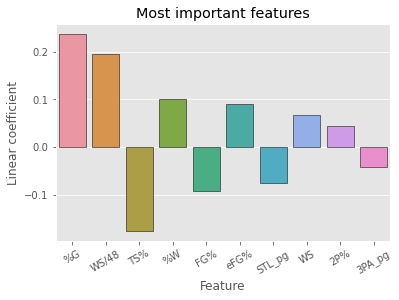

In [24]:
mod.display_linear_coef(model)

In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

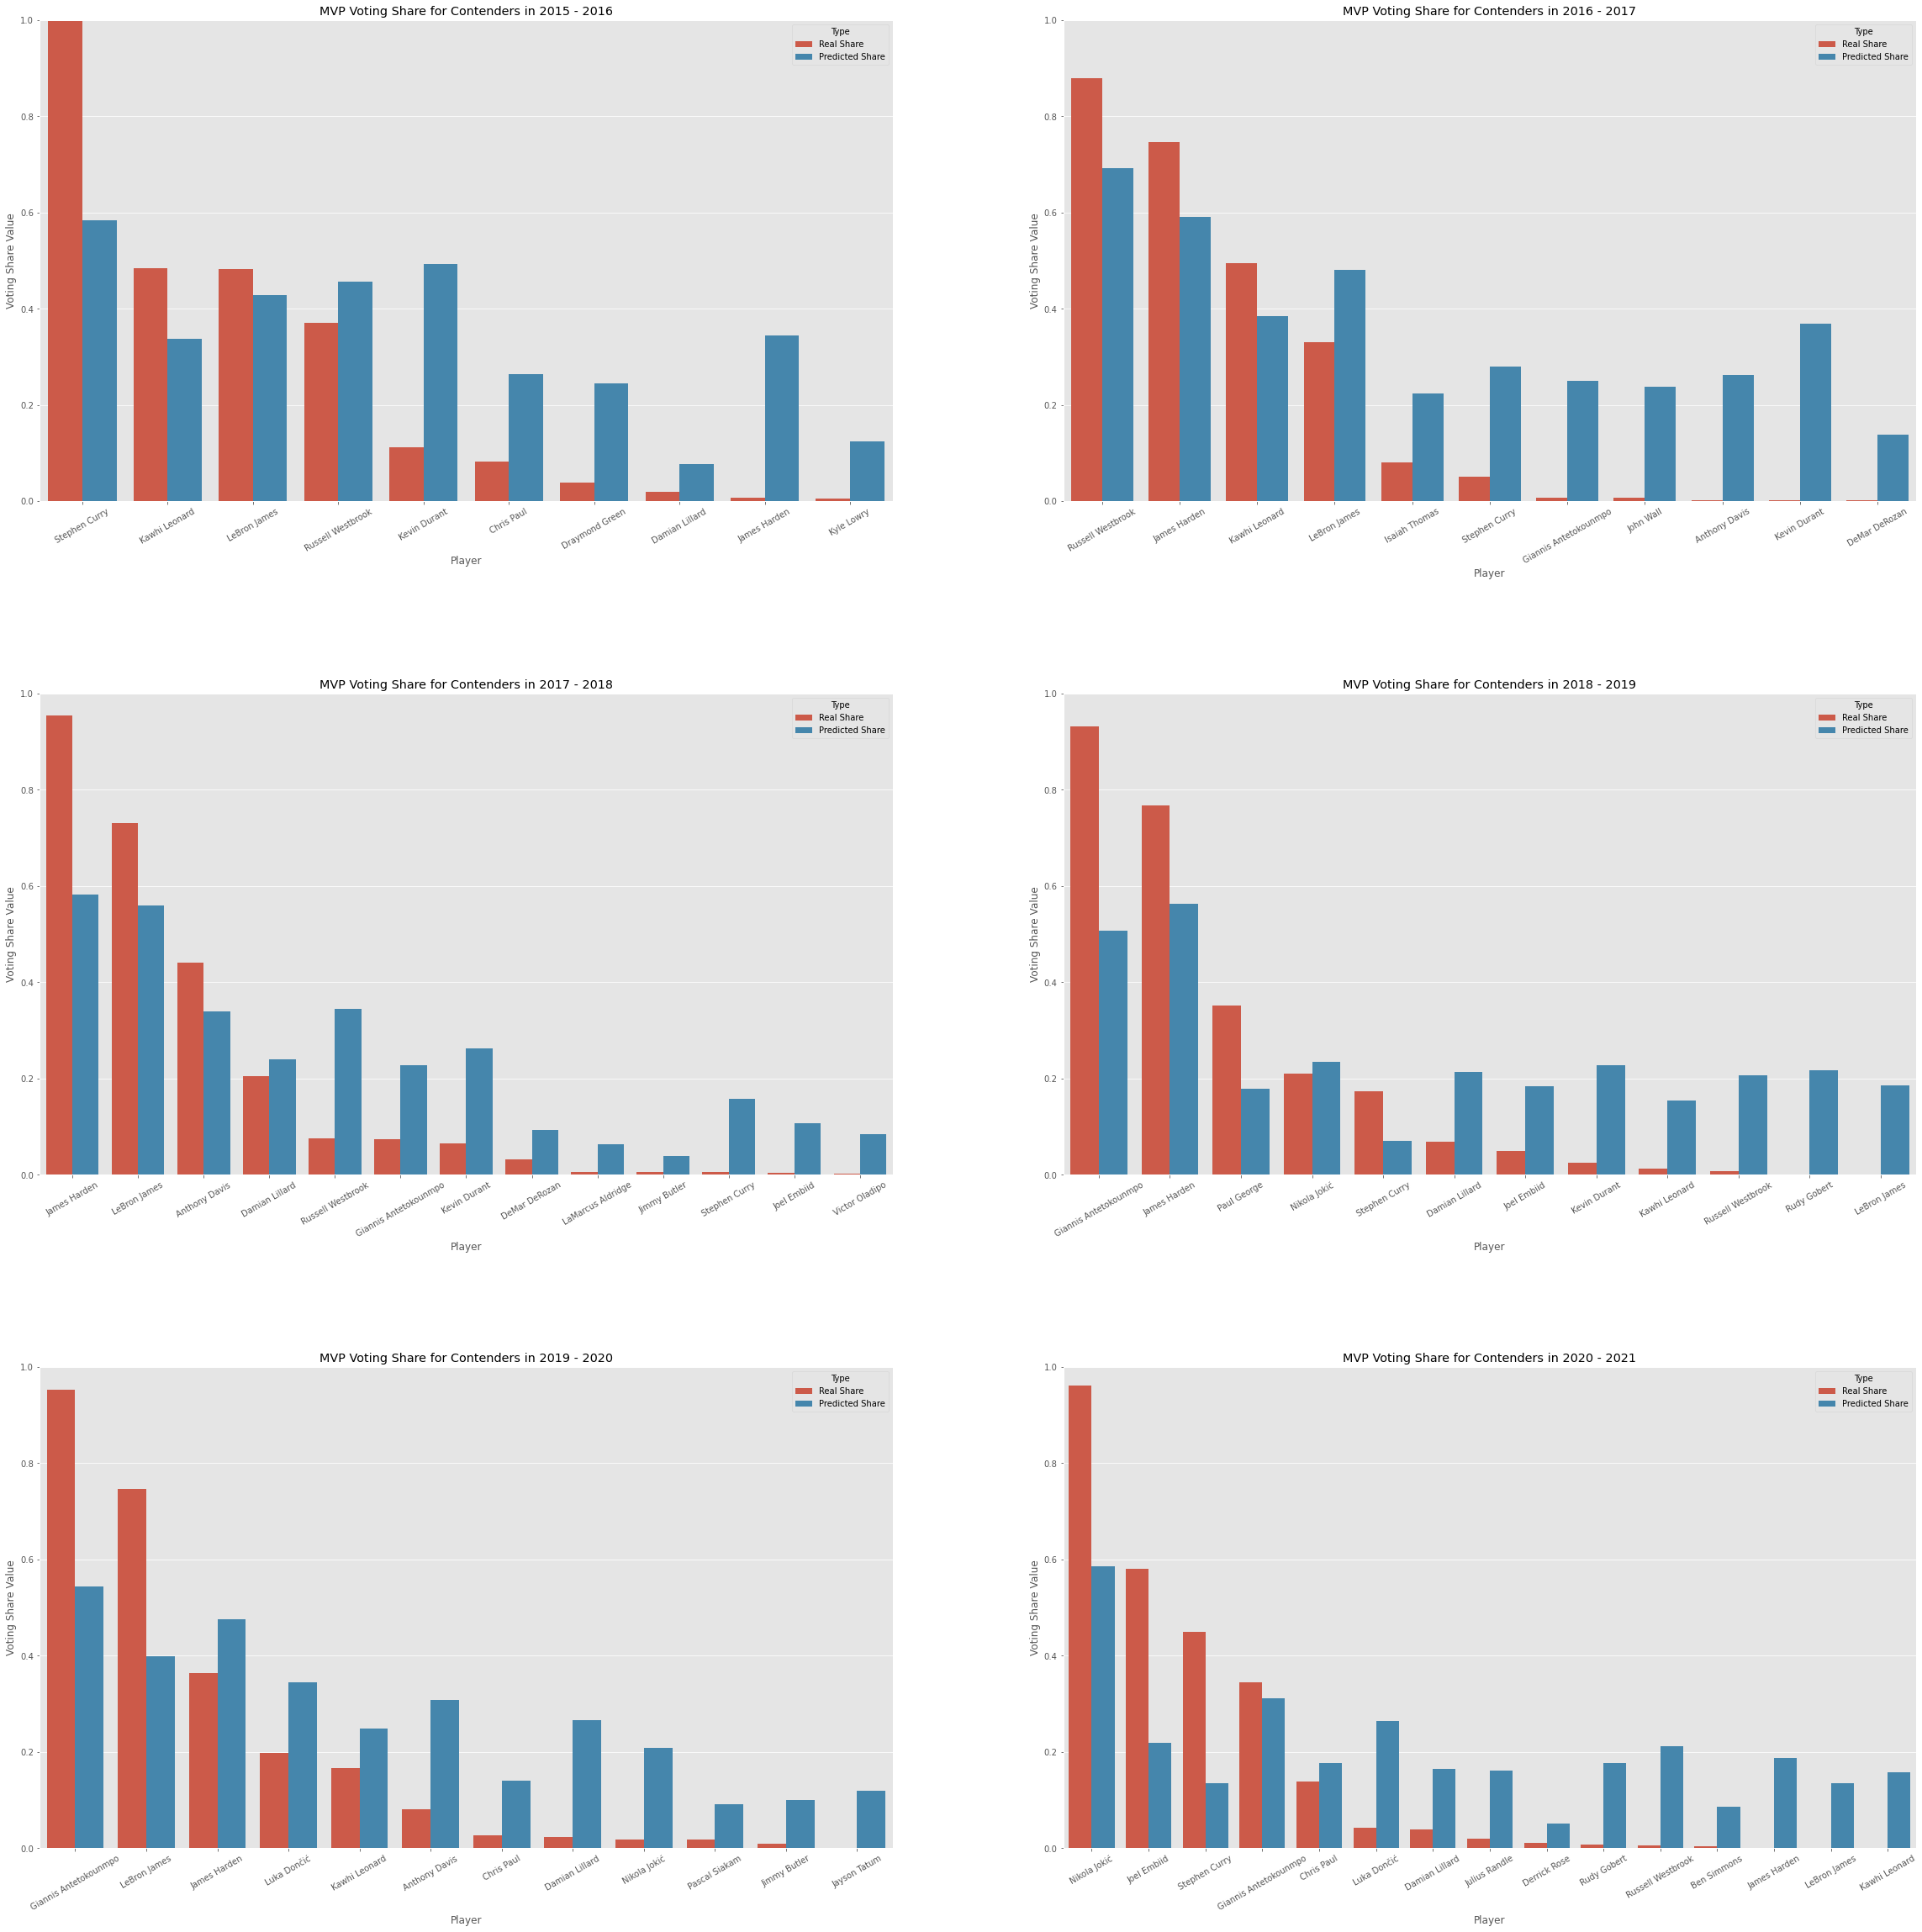

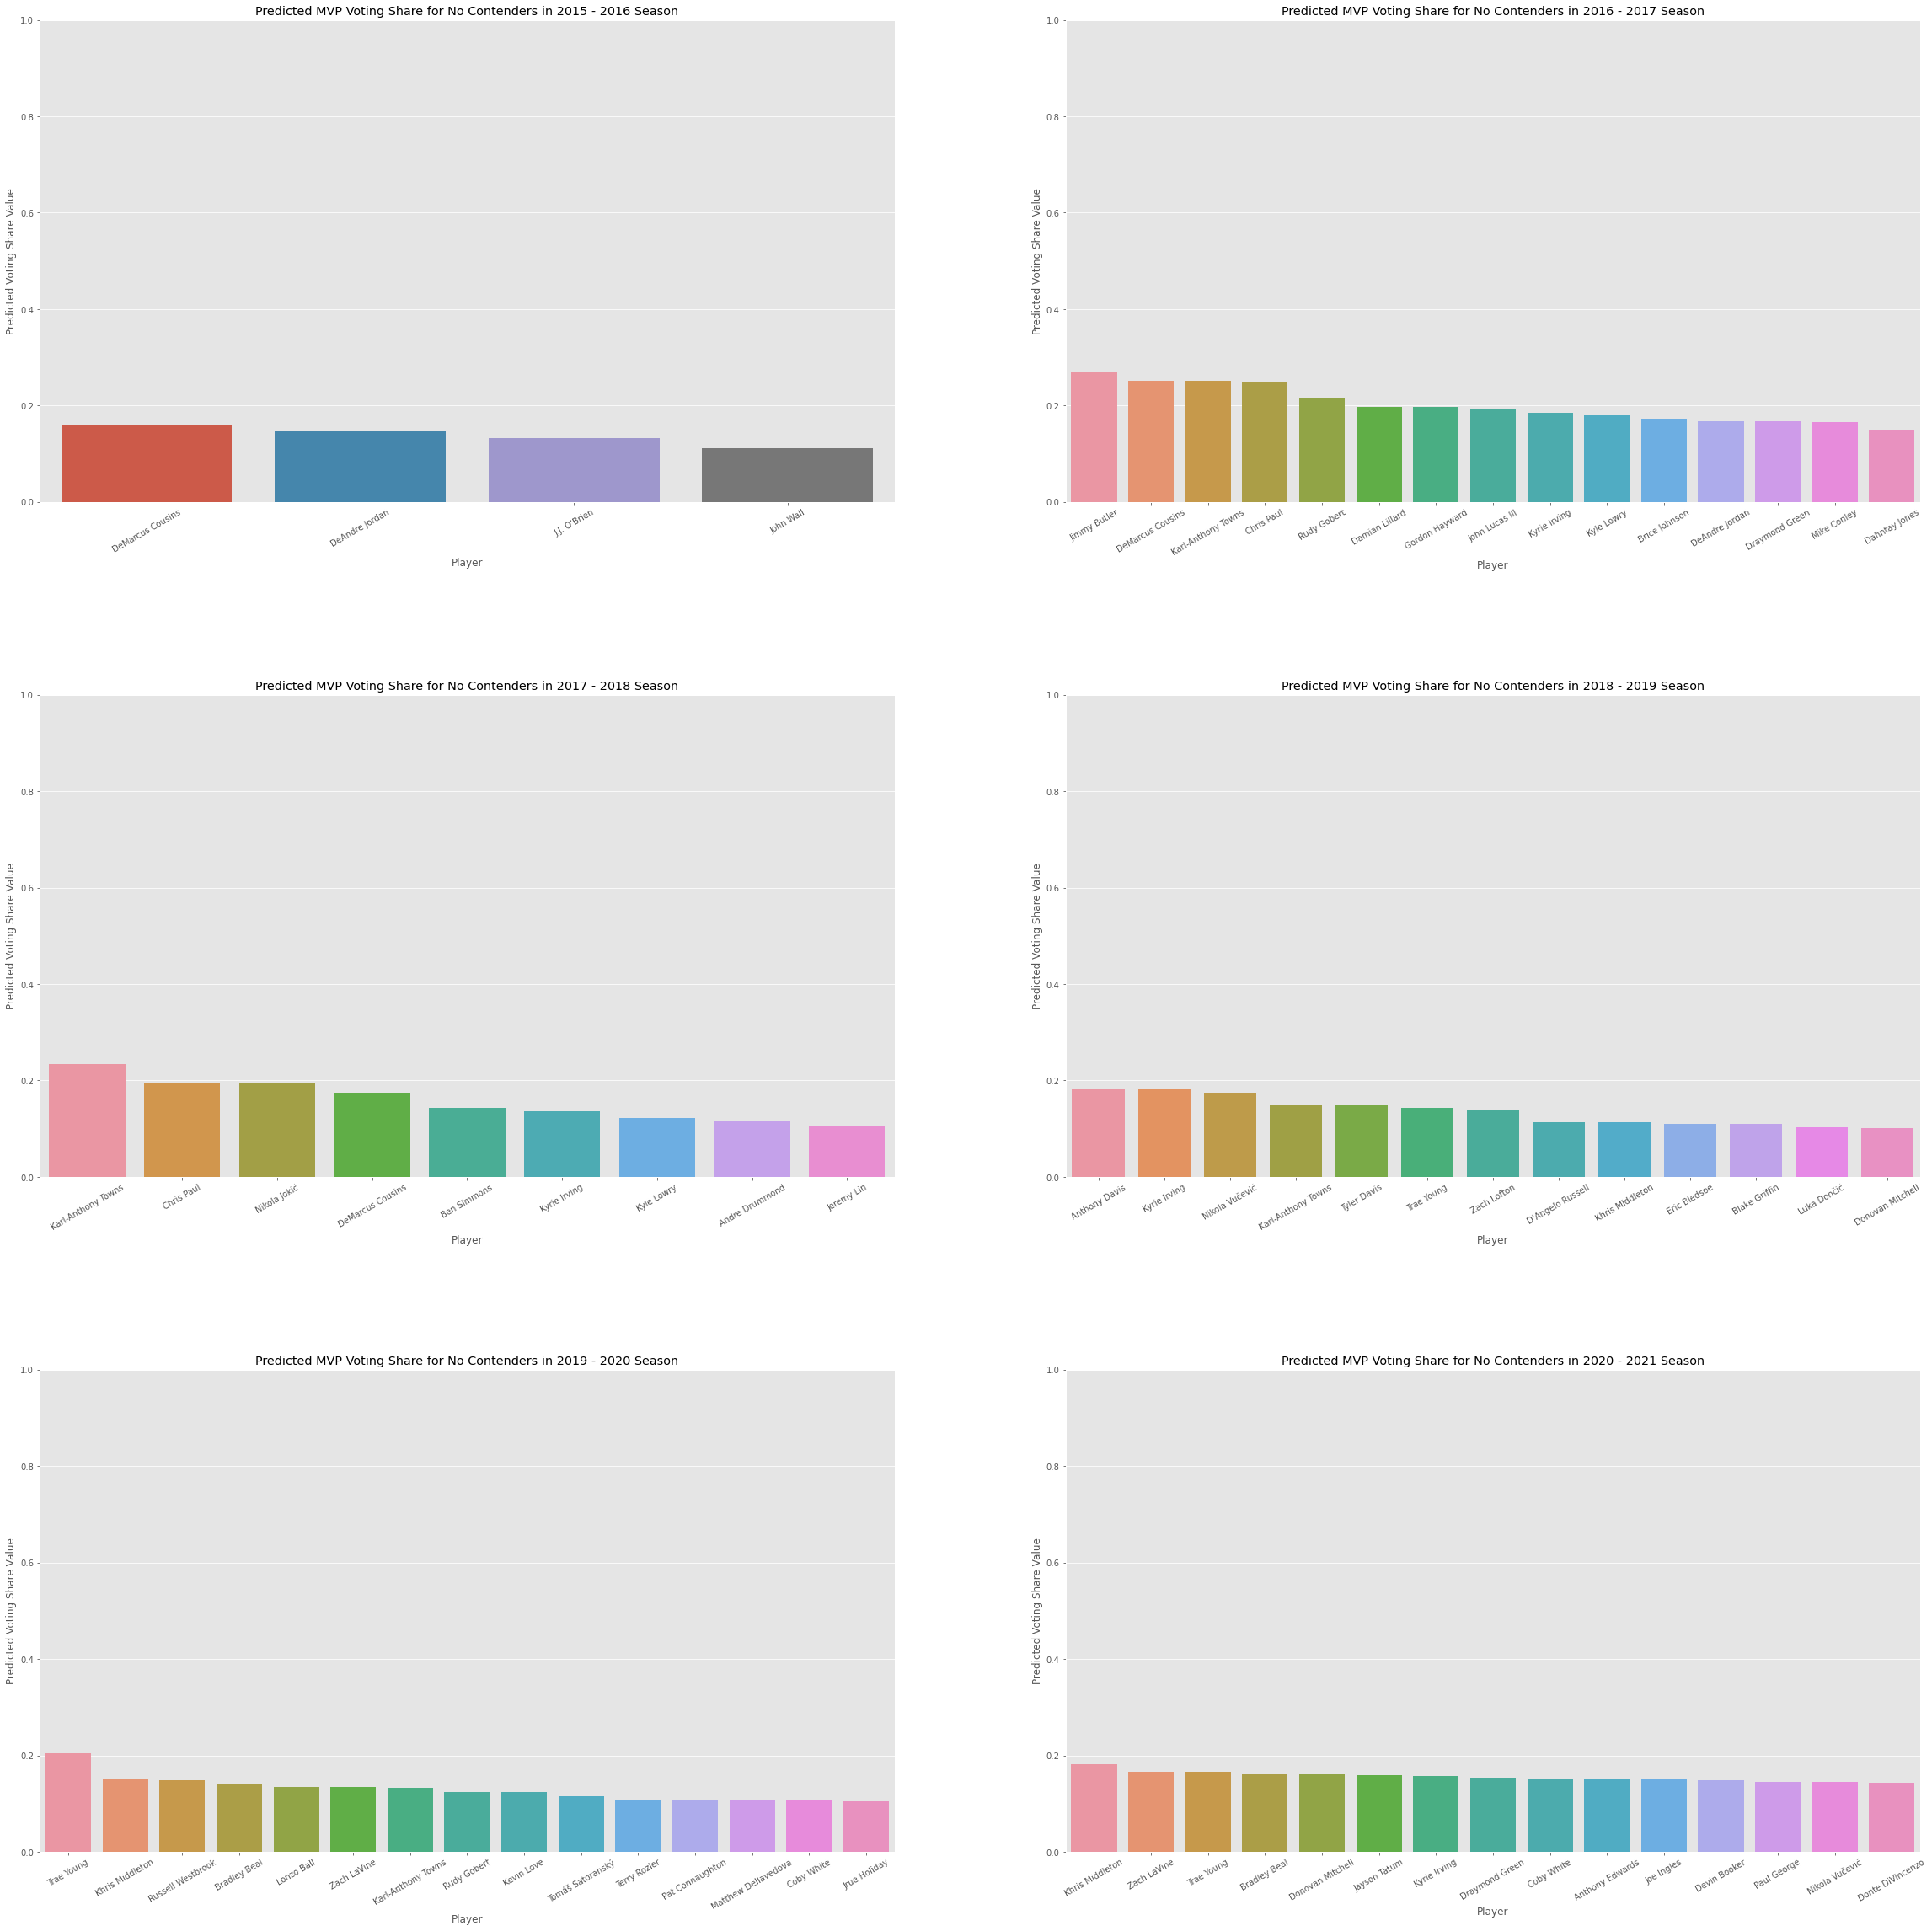

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [27]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [28]:
# top_features[top_features['Importance'] > 0.005]